In [1]:
# Don't use SVGs for this file because the images are too large,
# and the SVGs are much larger than their PNGs equivalents.
%config InlineBackend.figure_format='png'

# Transpile against custom backends

<details>
<summary><b>Package versions</b></summary>

The code on this page was developed using the following requirements.
We recommend using these versions or newer.

```
qiskit[all]~=1.3.2
qiskit-ibm-runtime~=0.34.0
qiskit-aer~=0.15.1
qiskit-serverless~=0.18.1
qiskit-ibm-catalog~=0.2
qiskit-addon-sqd~=0.9.0
qiskit-addon-utils~=0.1.0
qiskit-addon-mpf~=0.2.0
qiskit-addon-aqc-tensor~=0.1.2
qiskit-addon-obp~=0.1.0
scipy~=1.15.1
pyscf~=2.8.0; sys.platform != 'win32'
```
</details>

{/* cspell:ignore LOCC */}

One of the more powerful features of Qiskit is the ability to support unique device configurations.  Qiskit is built to be agnostic to the provider of the quantum hardware you use, and providers can configure the `BackendV2` object to their own unique device properties.  This topic demonstrates how to configure your own backend and transpile quantum circuits against them.

You can create unique `BackendV2` objects with different geometries or basis gates and transpile your circuits with those configurations in mind.  The example below covers a backend with a disjoint qubit lattice, whose basis gates are different along the edges from within the bulk.

## Understand the Provider, BackendV2, and Target interfaces

Before beginning, it is helpful to understand the usage and purpose of the [`Provider`](../api/qiskit/providers), [`BackendV2`](../api/qiskit/qiskit.providers.BackendV2), and [`Target`](../api/qiskit/qiskit.transpiler.Target) objects.

- If you have a quantum device or simulator that you want to integrate into the Qiskit SDK, you need to write your own `Provider` class. This class serves a single purpose: to get backend objects that you provide. This is where any required credential and/or authentication tasks are handled. Once instantiated, the provider object will then provide a list of backends as well as the ability to acquire/instantiate backends.

- Next, the backend classes provide the interface between the Qiskit SDK and the hardware or simulator that will execute circuits. They include all necessary information to describe a backend to the transpiler so that it can optimize any circuit according to its constraints. A `BackendV2` is built of four main parts:
  - A [`Target`](../api/qiskit/qiskit.transpiler.Target) property, which contains a description of the constraints of the backend and provides a model of the backend for the transpiler
  - A `max_circuits` property that defines a limit on the number of circuits a backend can execute in a single job
  - A `run()` method that accept job submissions
  - A set of `_default_options` to define the user configurable options and their default values

## Create a custom BackendV2

The `BackendV2` object is an abstract class used for all backend objects created by a provider (either within `qiskit.providers` or another library such as [`qiskit_ibm_runtime.IBMBackend`](../api/qiskit-ibm-runtime/ibm-backend)).  As mentioned above, these objects contain several attributes, including a [`Target`](/api/qiskit/qiskit.transpiler.Target). The `Target` contains information that specifies the backend's attributes - such as the [`Coupling Map`](/api/qiskit/qiskit.transpiler.CouplingMap), list of [`Instructions`](/api/qiskit/qiskit.circuit.Instruction), and others - to the transpiler.  In addition to the `Target`, one can also define pulse-level details such as the [`DriveChannel`](/api/qiskit/qiskit.pulse.channels.DriveChannel) or [`ControlChannel`](/api/qiskit/qiskit.pulse.channels.ControlChannel).

The following example demonstrates this customization by creating a simulated multi-chip backend, where each chip possesses a heavy-hex connectivity.  The example specifies the backend's two-qubit gate set to be [`CZGates`](../api/qiskit/qiskit.circuit.library.CZGate) within each chip and [`CXGates`](../api/qiskit/qiskit.circuit.library.ECRGate) between chips.  First, create your own `BackendV2` and customize its `Target` with single and two-qubit gates according to the previously described constraints.

<Admonition type="tip" title="graphviz library">
Plotting a coupling map requires the [`graphviz`](https://graphviz.org/) library to be installed.
</Admonition>

In [2]:
import numpy as np
import rustworkx as rx

from qiskit.providers import BackendV2, Options
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import XGate, SXGate, RZGate, CZGate, ECRGate
from qiskit.circuit import Measure, Delay, Parameter, Reset
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_gate_map


class FakeLOCCBackend(BackendV2):
    """Fake multi chip backend."""

    def __init__(self, distance=3, number_of_chips=3):
        """Instantiate a new fake multi chip backend.

        Args:
            distance (int): The heavy hex code distance to use for each chips'
                coupling map. This number **must** be odd. The distance relates
                to the number of qubits by:
                :math:`n = \\frac{5d^2 - 2d - 1}{2}` where :math:`n` is the
                number of qubits and :math:`d` is the ``distance``
            number_of_chips (int): The number of chips to have in the multichip backend
                each chip will be a heavy hex graph of ``distance`` code distance.
        """
        super().__init__(name="Fake LOCC backend")
        # Create a heavy-hex graph using the rustworkx library, then instantiate a new target
        self._graph = rx.generators.directed_heavy_hex_graph(
            distance, bidirectional=False
        )
        num_qubits = len(self._graph) * number_of_chips
        self._target = Target(
            "Fake multi-chip backend", num_qubits=num_qubits
        )

        # Generate instruction properties for single qubit gates and a measurement, delay,
        #  and reset operation to every qubit in the backend.
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        sx_props = {}
        measure_props = {}
        delay_props = {}

        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            sx_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1),
                duration=rng.uniform(1e-8, 9e-7),
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)

        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        # Add chip local 2q gate which is CZ
        cz_props = {}
        for i in range(number_of_chips):
            for root_edge in self._graph.edge_list():
                offset = i * len(self._graph)
                edge = (root_edge[0] + offset, root_edge[1] + offset)
                cz_props[edge] = InstructionProperties(
                    error=rng.uniform(7e-4, 5e-3),
                    duration=rng.uniform(1e-8, 9e-7),
                )
        self._target.add_instruction(CZGate(), cz_props)

        cx_props = {}
        # Add interchip 2q gates which are ecr (effectively CX)
        # First determine which nodes to connect
        node_indices = self._graph.node_indices()
        edge_list = self._graph.edge_list()
        inter_chip_nodes = {}
        for node in node_indices:
            count = 0
            for edge in edge_list:
                if node == edge[0]:
                    count += 1
            if count == 1:
                inter_chip_nodes[node] = count
        # Create inter-chip ecr props
        cx_props = {}
        inter_chip_edges = list(inter_chip_nodes.keys())
        for i in range(1, number_of_chips):
            offset = i * len(self._graph)
            edge = (
                inter_chip_edges[1] + (len(self._graph) * (i - 1)),
                inter_chip_edges[0] + offset,
            )
            cx_props[edge] = InstructionProperties(
                error=rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )

        self._target.add_instruction(ECRGate(), cx_props)

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @property
    def graph(self):
        return self._graph

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError(
            "This backend does not contain a run method"
        )

### Visualize backends

You can view the connectivity graph of this new class with the [`plot_gate_map()`](../api/qiskit/qiskit.visualization.plot_gate_map) method from the `qiskit.visualization` module.  This method, along with [`plot_coupling_map()`](../api/qiskit/qiskit.visualization.plot_coupling_map) and [`plot_circuit_layout()`](../api/qiskit/qiskit.visualization.plot_circuit_layout), are helpful tools for visualizing the qubit arrangement of a backend, as well as how a circuit is laid out across the qubits of a backend.  This example creates a backend containing three small heavy-hex chips. It specifies a set of coordinates to arrange the qubits, as well as a set of custom colors for the differing two-qubit gates.

In [3]:
backend = FakeLOCCBackend(3, 3)


target = backend.target
coupling_map_backend = target.build_coupling_map()


coordinates = [
    (3, 1),
    (3, -1),
    (2, -2),
    (1, 1),
    (0, 0),
    (-1, -1),
    (-2, 2),
    (-3, 1),
    (-3, -1),
    (2, 1),
    (1, -1),
    (-1, 1),
    (-2, -1),
    (3, 0),
    (2, -1),
    (0, 1),
    (0, -1),
    (-2, 1),
    (-3, 0),
]

single_qubit_coordinates = []
total_qubit_coordinates = []


for coordinate in coordinates:
    total_qubit_coordinates.append(coordinate)

for coordinate in coordinates:
    total_qubit_coordinates.append(
        (-1 * coordinate[0] + 1, coordinate[1] + 4)
    )

for coordinate in coordinates:
    total_qubit_coordinates.append((coordinate[0], coordinate[1] + 8))


line_colors = ["#adaaab" for edge in coupling_map_backend.get_edges()]
ecr_edges = []

# Get tuples for the edges which have an ecr instruction attached
for instruction in target.instructions:
    if instruction[0].name == "ecr":
        ecr_edges.append(instruction[1])

for i, edge in enumerate(coupling_map_backend.get_edges()):
    if edge in ecr_edges:
        line_colors[i] = "#000000"

Fake LOCC backend


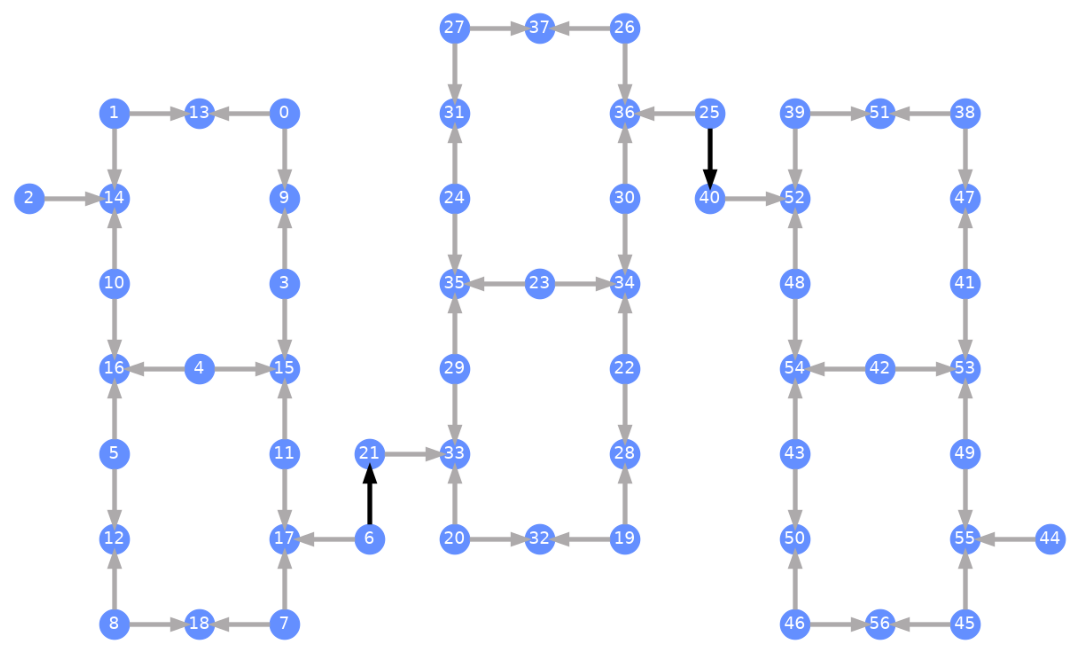

In [4]:
print(backend.name)
plot_gate_map(
    backend,
    plot_directed=True,
    qubit_coordinates=total_qubit_coordinates,
    line_color=line_colors,
)

Each qubit is labeled, and colored arrows represent the two-qubit gates.  Gray arrows are the CZ gates and the black arrows are the inter-chip CX gates (these connect qubits $6 \rightarrow 21$ and $25 \rightarrow 40$).  The direction of the arrow indicates the default direction in which these gates are executed; they specify which qubits are control/targets by default for each two-qubit channel.

## Transpile against custom backends

Now that a custom backend with its own unique [`Target`](../api/qiskit/qiskit.transpiler.Target) has been defined, it is straightforward to transpile quantum circuits against this backend, since all the relevant constraints (basis gates, qubit connectivity, and so forth) needed for transpiler passes are contained within this attribute. The next example builds a circuit that creates a large GHZ state and transpiles it against the backend constructed above.

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

num_qubits = 50
ghz = QuantumCircuit(num_qubits)
ghz.h(range(num_qubits))
ghz.cx(0, range(1, num_qubits))
op_counts = ghz.count_ops()

print("Pre-Transpilation: ")
print(f"CX gates: {op_counts['cx']}")
print(f"H gates: {op_counts['h']}")
print("\n", 30 * "#", "\n")

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled_ghz = pm.run(ghz)
op_counts = transpiled_ghz.count_ops()

print("Post-Transpilation: ")
print(f"CZ gates: {op_counts['cz']}")
print(f"ECR gates: {op_counts['ecr']}")
print(f"SX gates: {op_counts['sx']}")
print(f"RZ gates: {op_counts['rz']}")

Pre-Transpilation: 
CX gates: 49
H gates: 50

 ############################## 



Post-Transpilation: 
CZ gates: 155
ECR gates: 8
SX gates: 318
RZ gates: 226


The transpiled circuit now contains a mixture of `CZ` and `ECR` gates,which we specified as the basis gates in the backend's `Target`.  There are also quite a few more gates than you started with because of the need to insert SWAP instructions after choosing a layout.  Below, the [`plot_circuit_layout()`](/api/qiskit/qiskit.visualization.plot_circuit_layout) visualization tool is used to specify which qubits and two-qubit channels were used in this circuit.

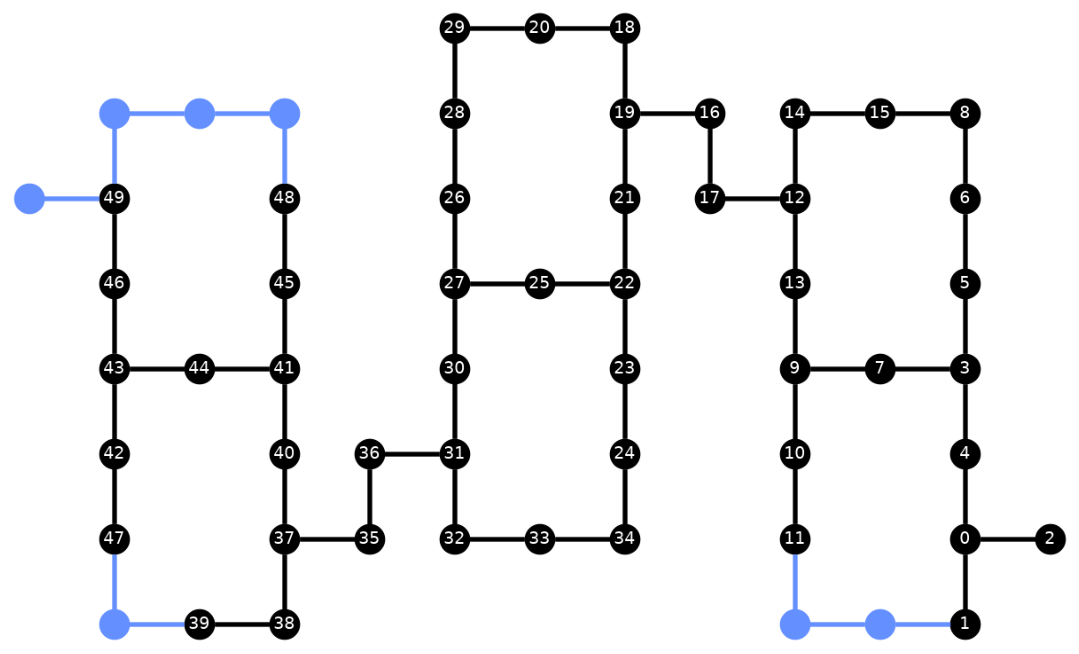

In [6]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(
    transpiled_ghz, backend, qubit_coordinates=total_qubit_coordinates
)

## Create unique backends

The [rustworkx](https://www.rustworkx.org/) package contains a large library of different graphs and enables the creation of custom graphs.  The visually interesting code below creates a backend inspired by the toric code. You can then visualize the backend using the functions from the [Visualize backends](#visualize-backends) section.

In [7]:
class FakeTorusBackend(BackendV2):
    """Fake multi chip backend."""

    def __init__(self):
        """Instantiate a new backend that is inspired by a toric code"""
        super().__init__(name="Fake LOCC backend")
        graph = rx.generators.directed_grid_graph(20, 20)
        for column in range(20):
            graph.add_edge(column, 19 * 20 + column, None)
        for row in range(20):
            graph.add_edge(row * 20, row * 20 + 19, None)
        num_qubits = len(graph)
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        sx_props = {}
        measure_props = {}
        delay_props = {}
        self._target = Target("Fake Kookaburra", num_qubits=num_qubits)
        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            sx_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1),
                duration=rng.uniform(1e-8, 9e-7),
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)
        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        cz_props = {}
        for edge in graph.edge_list():
            cz_props[edge] = InstructionProperties(
                error=rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )
        self._target.add_instruction(CZGate(), cz_props)

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError("Lasciate ogne speranza, voi ch'intrate")

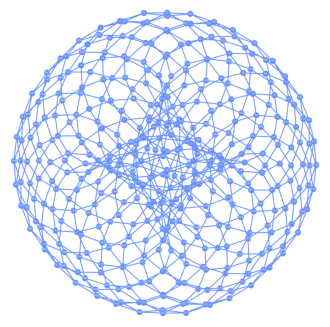

In [8]:
backend = FakeTorusBackend()
# We set `figsize` to a smaller size to make the documentation website faster
# to load. Normally, you do not need to set the argument.
plot_gate_map(backend, figsize=(4, 4))

In [9]:
num_qubits = int(backend.num_qubits / 2)
full_device_bv = QuantumCircuit(num_qubits, num_qubits - 1)
full_device_bv.x(num_qubits - 1)
full_device_bv.h(range(num_qubits))
full_device_bv.cx(range(num_qubits - 1), num_qubits - 1)
full_device_bv.h(range(num_qubits))
full_device_bv.measure(range(num_qubits - 1), range(num_qubits - 1))
tqc = transpile(full_device_bv, backend, optimization_level=3)
op_counts = tqc.count_ops()
print(f"CZ gates: {op_counts['cz']}")
print(f"X gates: {op_counts['x']}")
print(f"SX gates: {op_counts['sx']}")
print(f"RZ gates: {op_counts['rz']}")

CZ gates: 799
X gates: 6
SX gates: 1513
RZ gates: 913
